In [45]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
from langdetect import detect

# <div align="center"> Political social media posts

[Este dataset fue obtenido en la página Kaggle](https://www.kaggle.com/datasets/crowdflower/political-social-media-posts)


Consiste en 5000 publicaciones/posteos de las redes sociales (facebook y twitter) de políticos estadounidense (senadores y representantes del congreso). Los mensajes fueron clasificados según: audiencia (nacional o local), sesgo (neutral/bipartisan, o biased/partisan) y por el objetivo de los mismos (ataque, apoyo, personal, etc).

El dataset original cuenta con estas columnas:
1. `` _unit_id `` : un id único para cada mensaje
2. ``golden``: siempre FALSE (falso) → La columna fue eliminada
3. ``_unit_state``: siempre "finalized" (finalizado) → La columna fue eliminada
4. ``_trusted_judgments``: el cantidad de personas que juzgaron el mensaje; un número entero entre 1 y 3
5. ``_last_judgment_at``: cuando fue reoclectado el ulitmo "juicio"
6. ``audience``: público al que fue dirigido; nacional o circunscripto
7. ``audience:confidence``: una medida de confianza en el juicio de la audiencia; un número entre 0,5 y 1 → columna eliminada
8. ``bias``: el sesgo que se presenta como neutral o partidario
9. ``bias:confidence``: una medida de confianza en el juicio de sesgo; un valor entre 0,5 y 1 → columna eliminada
10. ``message``: el objetivo del mensaje:
    - attack: el mensaje ataca a otro político
    - constituency: el mensaje habla de la circunscripción del político
    - information: n mensaje informativo sobre las novedades del gobierno o de los Estados Unidos en general
    - media: un mensaje sobre la interacción con los medios de comunicación
    - Mobilization: mensaje destinado a movilizar a los partidarios.
    - other: una categoría que engloba los mensajes que no encajan en las otras categorías.
    - personal: un mensaje personal, que suele expresar simpatía, apoyo y/o condolencias, u otras opiniones personales
    - policy: un mensaje sobre políticas
    - support: un mensaje de apoyo político
11. ``message:confidence``: una medida de confianza en el juicio del mensaje; un valor entre 0,5 y 1 → columna eliminada
12. ``orig_golden``: siempre vacío; presumiblemente si alguna parte del mensaje estaba en el estándar de oro → columna eliminada
13. ``audience_gold``: siempre vacío; presumiblemente si la respuesta de la audiencia estaba en el patrón oro → columna eliminada
14. ``bias_gold``: siempre vacío; presumiblemente, si la respuesta de sesgo estaba en el patrón oro → columna eliminada
15. ``bioid``: un id único para el político
16. ``embed``: código HTML para incrustar este mensaje → columna eliminada
17. ``id``: id único del mensaje DENTRO del sitio de medios sociales del que se extrajo
18. ``label``: una frase de la forma "De: nombre apellido (cargo del estado)"
19. ``message_gold``: siempre en blanco; presumiblemente si la respuesta del mensaje estaba en el estándar de oro → columna eliminada
20. ``source``: donde se publicó el mensaje,"facebook" o "twitter"
21. ``text``: el texto del mensaje

Como fue indicado, varias columnas no fueron seleccionadas (eliminadas), ya que estaban relacionadas al proceso de construcción del dataset que no tiene relevancia ahora, siendo que no todas las filas están vacías o todas tienen el mismo valor.

El objetivo es poder establecer las relaciones entre las variables y ver la influencia que tienen sobre el tipo de publicación. Se buscará poder **predecir el tipo/intención de la publicación**. En el futuro, estaría bueno poder aplicar lo que se logre, automatizarlo y poder detectar de que tipo de posteo se trata, y si se puede utilizar para Argentina mejor (aunque es cierto que hay elementos que dependen mucho del contexto politico y social)

Por lo tanto, nuestra variable dependiente es **"message"**, y el resto las independientes (luego se elegirán las más adecuadas)

Para ellos se crearán variables tomando las ya existentes, y las palabras dentro de los textos.

Como hipótesis inicial, se cree que para cada una de las diferentes intenciones de los mensajes, se utilizan diferentes palabras claves, además el sesgo (bias) va a influir, ya que si es partidario será más de ataque y si es neutral más de apoyo, por ejemplo.

In [46]:
file = "../data/political_social_media.csv"
political_posts = pd.read_csv(file, encoding_errors = "ignore", usecols= ['_unit_id',
       '_last_judgment_at', 'audience', 'bias', 'message', 'bioid', 'id', 'label', 'source', 'text'])
political_posts.head(2)

,_unit_id,_last_judgment_at,audience,bias,message,bioid,id,label,source,text
0,766192484,8/4/15 21:17,national,partisan,policy,R000596,3.83249E+17,From: Trey Radel (Representative from Florida),twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...
1,766192485,8/4/15 21:20,national,partisan,attack,M000355,3.11208E+17,From: Mitch McConnell (Senator from Kentucky),twitter,VIDEO - #Obamacare: Full of Higher Costs and ...


# 1- Dimensiones e información

In [47]:
dimensiones = political_posts.shape
print(f'El dataset cuenta con {dimensiones[0]} resgistros y {dimensiones[1]} columnas')

El dataset cuenta con 5000 resgistros y 10 columnas


In [48]:
political_posts.columns

Index(['_unit_id', '_last_judgment_at', 'audience', 'bias', 'message', 'bioid',
       'id', 'label', 'source', 'text'],
      dtype='object')

In [49]:
political_posts.rename(columns={'_unit_id': 'unit_id', '_last_judgment_at': 'last_judgment_date', 'bioid': 'politico_id','id': 'mensaje_id_sitio' }, inplace=True)
political_posts.columns

Index(['unit_id', 'last_judgment_date', 'audience', 'bias', 'message',
       'politico_id', 'mensaje_id_sitio', 'label', 'source', 'text'],
      dtype='object')

#### Tipos de datos y cambio

In [50]:
political_posts.dtypes

unit_id                int64
last_judgment_date    object
audience              object
bias                  object
message               object
politico_id           object
mensaje_id_sitio      object
label                 object
source                object
text                  object
dtype: object

In [51]:
political_posts.last_judgment_date = pd.to_datetime(political_posts.last_judgment_date)
political_posts.dtypes

unit_id                        int64
last_judgment_date    datetime64[ns]
audience                      object
bias                          object
message                       object
politico_id                   object
mensaje_id_sitio              object
label                         object
source                        object
text                          object
dtype: object

#### Fechas

In [52]:
print(f"El periodo que se analizaron las publicaciones fue desde:{min(political_posts.last_judgment_date)}, hasta: {max(political_posts.last_judgment_date)}")

El periodo que se analizaron las publicaciones fue desde:2015-08-04 20:02:00, hasta: 2015-08-05 14:55:00


Durante este periodo, el presidente de los Estados UNidos era Barack Obama, siendo parte del partido Democrata

In [53]:
political_posts.message.unique()

array(['policy', 'attack', 'support', 'information', 'mobilization',
       'personal', 'other', 'constituency', 'media'], dtype=object)

# 2- Faltantes

In [54]:
political_posts.isna().sum()

unit_id               0
last_judgment_date    0
audience              0
bias                  0
message               0
politico_id           0
mensaje_id_sitio      0
label                 0
source                0
text                  0
dtype: int64

# 3- Duplicados

In [55]:
cantidad_duplicados = len(political_posts) - len(political_posts.drop_duplicates())
print(f"Hay {cantidad_duplicados} duplicados")

Hay 0 duplicados


# 4- Creo algunas variables

## Cantidad de palabras

Creo la columna: cantidad de palabras, para ver si luego encuentro una relacione entre esto y la intencion del mensaje

In [56]:
political_posts['cantidad_caracteres'] = political_posts.text.str.len()
political_posts.head()

,unit_id,last_judgment_date,audience,bias,message,politico_id,mensaje_id_sitio,label,source,text,cantidad_caracteres
0,766192484,2015-08-04 21:17:00,national,partisan,policy,R000596,3.83249E+17,From: Trey Radel (Representative from Florida),twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...,93
1,766192485,2015-08-04 21:20:00,national,partisan,attack,M000355,3.11208E+17,From: Mitch McConnell (Senator from Kentucky),twitter,VIDEO - #Obamacare: Full of Higher Costs and ...,85
2,766192486,2015-08-04 21:14:00,national,neutral,support,S001180,3.39069E+17,From: Kurt Schrader (Representative from Oregon),twitter,Please join me today in remembering our fallen...,136
3,766192487,2015-08-04 21:08:00,national,neutral,policy,C000880,2.98528E+17,From: Michael Crapo (Senator from Idaho),twitter,RT @SenatorLeahy: 1st step toward Senate debat...,122
4,766192488,2015-08-04 21:26:00,national,partisan,policy,U000038,4.07643E+17,From: Mark Udall (Senator from Colorado),twitter,.@amazon delivery #drones show need to update ...,143


In [57]:
political_posts.describe()

,unit_id,cantidad_caracteres
count,5.000000e+03,5000.000000
mean,7.661950e+08,204.396400
std,1.444060e+03,301.226757
min,7.661925e+08,1.000000
25%,7.661937e+08,112.000000
50%,7.661950e+08,137.000000
75%,7.661962e+08,205.000000
max,7.661975e+08,14344.000000


### Analizo outliers

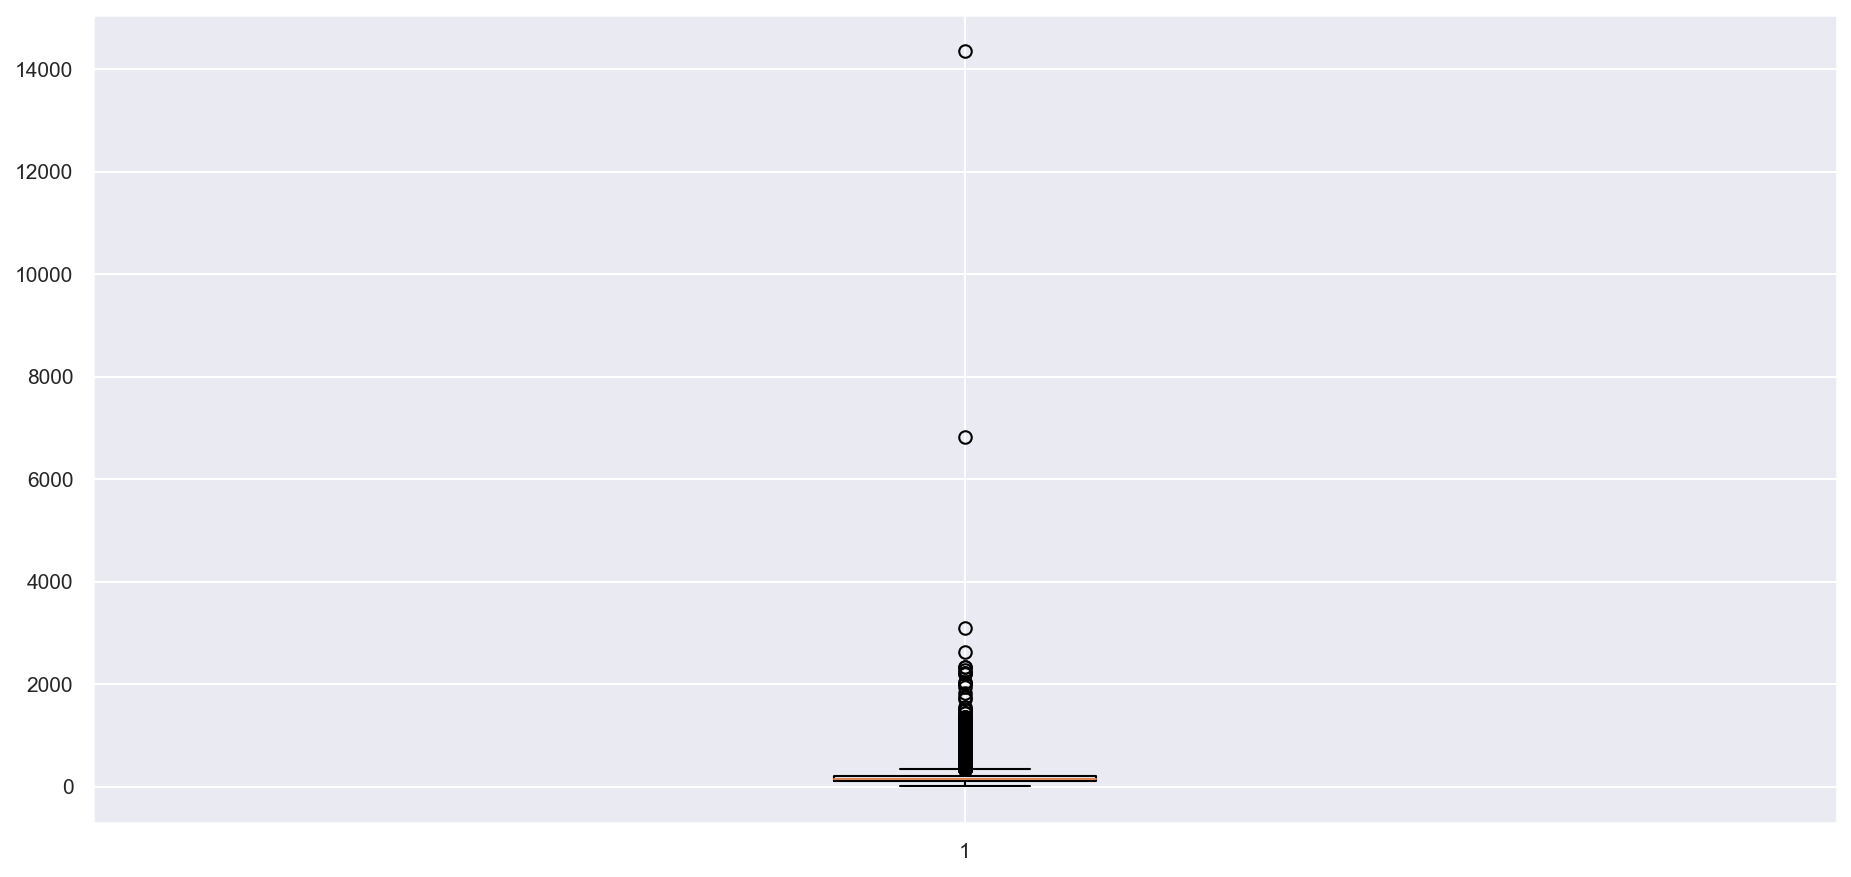

In [58]:
fig = plt.figure(figsize =(15, 7))
plt.boxplot(political_posts.cantidad_caracteres)
plt.show()

###### 280 es el limite de caracteres en twitter

In [59]:
posibles_outliers = political_posts[political_posts.cantidad_caracteres > 280]
posibles_outliers

,unit_id,last_judgment_date,audience,bias,message,politico_id,mensaje_id_sitio,label,source,text,cantidad_caracteres
2501,766194987,2015-08-05 04:43:00,national,neutral,information,A000055,19787529402_10151438053704403,From: Robert Aderholt (Representative from Ala...,facebook,"In today۪s challenging budgetary environment, ...",466
2503,766194989,2015-08-05 05:40:00,national,neutral,policy,A000360,89927603836_10151473528428837,From: Lamar Alexander (Senator from Tennessee),facebook,ICYMI: Sen. Alexander on Saturday delivered th...,628
2504,766194990,2015-08-05 05:40:00,national,neutral,policy,A000360,89927603836_10102170734377750,From: Lamar Alexander (Senator from Tennessee),facebook,"ICYMI: On the Senate floor yesterday, Sen. Ale...",442
2505,766194991,2015-08-05 05:13:00,national,neutral,policy,A000367,173604349345646_858910437481697,From: Justin Amash (Representative from Michigan),facebook,"I voted yes on #HR2, American Energy Solutions...",303
2506,766194992,2015-08-05 06:02:00,national,partisan,policy,A000367,173604349345646_727641740608568,From: Justin Amash (Representative from Michigan),facebook,Congressman Ron DeSantis endorses Rep. Ra̼l R....,1234
...,...,...,...,...,...,...,...,...,...,...,...
4992,766197479,2015-08-05 05:36:00,national,neutral,media,Y000064,186203844738421_278220632312018,From: Todd Young (Representative from Indiana),facebook,Take a look at a recent article in the Corydon...,307
4994,766197481,2015-08-05 05:39:00,national,neutral,personal,Y000065,563532937006022_1005685512790760,From: Ted Yoho (Representative from Florida),facebook,I was honored to host the Discovery Channel in...,350
4995,766197482,2015-08-05 06:05:00,national,partisan,support,Y000065,563532937006022_939071892785456,From: Ted Yoho (Representative from Florida),facebook,I applaud Governor Perry۪s recent decision to ...,350
4996,766197483,2015-08-05 05:57:00,national,partisan,policy,Y000065,563532937006022_936080056417973,From: Ted Yoho (Representative from Florida),facebook,"Today, I voted in favor of H.R. 5016 - Financi...",841


In [60]:
posibles_outliers.source.unique()

array(['facebook'], dtype=object)

Esta cantidad es posible, ya que es una publicacion de facebook, y no hay limitaciones al respecto en esta red social

## Usuario, cargo y estado

Tomo la columna label, y a partir de ella, creo: usuario, cargo y estado. Para asi poder analizar por separado

In [61]:
political_posts['usuario'] = political_posts.label.apply(lambda x: x.split(": ")[1]).apply(lambda x: x.split(" (")[0])
political_posts['cargo'] = political_posts.label.apply(lambda x: x.split("(")[1]).apply(lambda x: x.split(" ")[0])
political_posts['estado'] = political_posts.label.apply(lambda x: x.split("from ")[1]).apply(lambda x: x.split(")")[0])
political_posts.drop('label', inplace=True, axis=1)
political_posts.head()

,unit_id,last_judgment_date,audience,bias,message,politico_id,mensaje_id_sitio,source,text,cantidad_caracteres,usuario,cargo,estado
0,766192484,2015-08-04 21:17:00,national,partisan,policy,R000596,3.83249E+17,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...,93,Trey Radel,Representative,Florida
1,766192485,2015-08-04 21:20:00,national,partisan,attack,M000355,3.11208E+17,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...,85,Mitch McConnell,Senator,Kentucky
2,766192486,2015-08-04 21:14:00,national,neutral,support,S001180,3.39069E+17,twitter,Please join me today in remembering our fallen...,136,Kurt Schrader,Representative,Oregon
3,766192487,2015-08-04 21:08:00,national,neutral,policy,C000880,2.98528E+17,twitter,RT @SenatorLeahy: 1st step toward Senate debat...,122,Michael Crapo,Senator,Idaho
4,766192488,2015-08-04 21:26:00,national,partisan,policy,U000038,4.07643E+17,twitter,.@amazon delivery #drones show need to update ...,143,Mark Udall,Senator,Colorado


In [62]:
political_posts.cargo.unique()

array(['Representative', 'Senator'], dtype=object)

In [63]:
posts_mensaje_cargo = political_posts.groupby(['message', 'cargo']).agg(
    cantidad_de_posts =  ('unit_id', 'count')).pivot_table( values='cantidad_de_posts', index=['message'],columns=['cargo']).apply(lambda x: x/x.sum() * 100)
posts_mensaje_cargo

cargo,Representative,Senator
message,,
attack,3.527950,3.076923
constituency,3.229814,2.256410
information,13.341615,11.282051
media,5.416149,6.051282
mobilization,2.608696,2.461538
other,2.633540,1.538462
personal,23.975155,21.025641
policy,27.155280,32.615385
support,18.111801,19.692308


In [64]:
political_posts.estado.value_counts()

Texas             494
California        486
Florida           298
New York          224
Ohio              183
Illinois          183
Pennsylvania      177
Arizona           144
New Jersey        137
North Carolina    134
Indiana           132
Michigan          129
Virginia          121
Tennessee         112
Maryland          108
Missouri          101
Louisiana          99
Kansas             98
Kentucky           88
Washington         85
Arkansas           84
Connecticut        83
Massachusetts      83
South Carolina     78
Alabama            77
Minnesota          77
Georgia            76
Colorado           72
Wisconsin          69
New Mexico         61
Vermont            56
West Virginia      53
Rhode Island       51
Nevada             50
Idaho              47
New Hampshire      47
North Dakota       47
Iowa               45
Oregon             44
Utah               38
Mississippi        32
Oklahoma           31
Delaware           27
Alaska             26
Wyoming            21
NA        

In [65]:
political_posts[political_posts.estado == 'NA']

,unit_id,last_judgment_date,audience,bias,message,politico_id,mensaje_id_sitio,source,text,cantidad_caracteres,usuario,cargo,estado
118,766192603,2015-08-04 21:26:00,national,neutral,personal,N000147,5.25408E+17,twitter,"Looking for Job? Help me, help residents looki...",138,Eleanor Norton,Representative,NA
1004,766193489,2015-08-04 21:19:00,national,neutral,support,N000147,3.7309E+17,twitter,"My interview w/ @NiaWaPo on @PostTV, discussin...",108,Eleanor Norton,Representative,NA
1440,766193925,2015-08-04 21:05:00,national,partisan,information,N000147,5.35173E+17,twitter,Government-to-Go: Need help with a federal age...,138,Eleanor Norton,Representative,NA
2612,766195098,2015-08-05 05:34:00,national,neutral,personal,B001245,161729837225622_770524009679532,facebook,I continue to accept applications for nominati...,308,Madeleine Bordallo,Representative,NA
2613,766195099,2015-08-05 05:51:00,national,neutral,support,B001245,161729837225622_507743285957607,facebook,Congresswoman Bordallo joins Members of Congre...,267,Madeleine Bordallo,Representative,NA
2614,766195100,2015-08-05 04:52:00,national,neutral,personal,B001245,161729837225622_505586199506649,facebook,I am deeply saddened at the loss of SGT Eugene...,428,Madeleine Bordallo,Representative,NA
4237,766196723,2015-08-05 05:38:00,national,neutral,personal,P000596,55139978107_10151944179033108,facebook,En breve AL AIRE junto a Kike Cruz por Notiuno...,52,Pedro Pierluisi,Representative,NA
4238,766196724,2015-08-05 05:53:00,national,neutral,support,P000596,55139978107_10151678669533108,facebook,@ Fideicomiso de Conservaci_nPR revisando los ...,116,Pedro Pierluisi,Representative,NA
4239,766196725,2015-08-05 06:20:00,national,neutral,information,P000596,55139978107_10151651535108108,facebook,http://www.metro.pr/locales/guardia-costera-co...,107,Pedro Pierluisi,Representative,NA
4240,766196726,2015-08-05 14:06:00,national,neutral,support,P000596,55139978107_10151638681248108,facebook,Los pagos de hospitalizaci_n promedio de Medic...,525,Pedro Pierluisi,Representative,NA


Según la Constitución de EE.UU., sólo los estados pueden estar representados en el Congreso de los Estados Unidos, por lo que hay territorios que no tienen representación con derecho a voto.
En su lugar, los electores del distrito eligen a un delegado sin derecho a voto en la Cámara de Representantes de los Estados Unidos. Y tampoco pueden votar en las elecciones presidenciales.
Según la Cámara de Representantes de 2015:
- Eleanor Holmes Norton --> District of Columbia
- Madeline Bordallo --> Guam
- Pedro Pierlusi --> Puerto Rico
- Gregorio 'Kilili' Sablan --> Northern Mariana Islands


In [66]:
political_posts.loc[political_posts['usuario'] == 'Eleanor Norton', 'estado'] = 'District of Columbia'
political_posts.loc[political_posts['usuario'] == 'Madeleine Bordallo', 'estado'] = 'Guam'
political_posts.loc[political_posts['usuario'] == 'Pedro Pierluisi', 'estado'] = 'Puerto Rico'
political_posts.loc[political_posts['politico_id'] == 'S001177', 'estado'] = 'Northern Mariana Islands'

len(political_posts[political_posts.estado == 'NA'])

0

In [67]:
cantidad_de_caracteres_mensaje = political_posts.groupby(['message']).agg(
    promedio_palabras =  ('cantidad_caracteres', 'mean'))
cantidad_de_caracteres_mensaje.sort_values('promedio_palabras', ascending = False)

,promedio_palabras
message,
policy,248.668320
support,206.707926
attack,203.918605
information,193.548686
mobilization,187.286822
personal,180.459829
constituency,164.611842
other,162.876033
media,145.870036


In [68]:
political_posts.politico_id.nunique()

505

In [69]:
def detectar_idioma(text):
    try:
        return detect(text)
    except:
        return "unknown"

political_posts['idioma'] = political_posts['text'].apply(detectar_idioma)
political_posts.head()

,unit_id,last_judgment_date,audience,bias,message,politico_id,mensaje_id_sitio,source,text,cantidad_caracteres,usuario,cargo,estado,idioma
0,766192484,2015-08-04 21:17:00,national,partisan,policy,R000596,3.83249E+17,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...,93,Trey Radel,Representative,Florida,en
1,766192485,2015-08-04 21:20:00,national,partisan,attack,M000355,3.11208E+17,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...,85,Mitch McConnell,Senator,Kentucky,en
2,766192486,2015-08-04 21:14:00,national,neutral,support,S001180,3.39069E+17,twitter,Please join me today in remembering our fallen...,136,Kurt Schrader,Representative,Oregon,en
3,766192487,2015-08-04 21:08:00,national,neutral,policy,C000880,2.98528E+17,twitter,RT @SenatorLeahy: 1st step toward Senate debat...,122,Michael Crapo,Senator,Idaho,en
4,766192488,2015-08-04 21:26:00,national,partisan,policy,U000038,4.07643E+17,twitter,.@amazon delivery #drones show need to update ...,143,Mark Udall,Senator,Colorado,en


###### Como los nombres de los idiomas están en código, se puede no entender cual es. Por lo tanto, hacemos un join con la siguiente tabla, para tener los nombres completos y entendibles

In [70]:
file_idiomas = "../data/idiomas.csv"
idiomas = pd.read_csv(file_idiomas)
idiomas.head()

,language_name,idioma
0,Abkhazian,ab
1,Afar,aa
2,Afrikaans,af
3,Akan,ak
4,Albanian,sq


In [71]:
political_posts = pd.merge(political_posts, idiomas, how='left')
political_posts.drop('idioma', inplace=True, axis=1)
political_posts.language_name.value_counts()

English                            4905
Spanish , Castilian                  37
German                                9
French                                5
Afrikaans                             5
Dutch , Flemish                       5
Italian                               4
Catalan , Valencian                   3
Tagalog                               2
Somali                                2
Norwegian                             2
Slovenian                             2
Danish                                1
Welsh                                 1
Romanian , Moldavian , Moldovan       1
Latvian                               1
Portuguese                            1
Turkish                               1
Indonesian                            1
Vietnamese                            1
Name: language_name, dtype: int64

In [72]:
political_posts[political_posts.language_name.isna()].text

432         http://t.co/Jj6T4Vk12x http://t.co/uE9KF7DQrF
2823                                              2/11/14
2874    http://www.politico.com/story/2014/08/lacy-cla...
3271                          http://youtu.be/cv1fjOWJDAE
3762                                                    .
3849                          http://youtu.be/Dn93xkYBnMk
3861                          http://youtu.be/TOsyw3X5wOI
4231    http://www.nydailynews.com/new-york/rangel-chi...
4250    https://www.youtube.com/watch?v=IJRAZWGYykM&fe...
4552     http://sessions.house.gov/index.cfm/weekly-ne...
4917    http://womack.congressnewsletter.net/mail/util...
Name: text, dtype: object

Se debe a que son links o hay un punto (seguramente haciendo referencia a un reposteo), o hay una fecha.

In [73]:
political_posts[political_posts.text == '.']

,unit_id,last_judgment_date,audience,bias,message,politico_id,mensaje_id_sitio,source,text,cantidad_caracteres,usuario,cargo,estado,language_name
3762,766196248,2015-08-05 06:00:00,national,partisan,policy,L000263,223726364320243_1090155251010679,facebook,.,1,Sander Levin,Representative,Michigan,NaN


In [74]:
political_posts[political_posts.text == '2/11/14']

,unit_id,last_judgment_date,audience,bias,message,politico_id,mensaje_id_sitio,source,text,cantidad_caracteres,usuario,cargo,estado,language_name
2823,766195309,2015-08-05 05:54:00,national,neutral,personal,C001056,75755694423_10152211852589424,facebook,2/11/14,7,John Cornyn,Senator,Texas,NaN


Es un mensaje personal, entonces debe tener una conexión con la persona

In [75]:
political_posts_not_english = political_posts[political_posts.language_name != 'English']
political_posts_not_english[['text', 'language_name']]

,text,language_name
55,Demandar Obama un recuento en #Venezuela? Creo...,"Spanish , Castilian"
167,Apropiado q Maduro + Ortega juntos en #Nicarag...,"Spanish , Castilian"
169,@dwaynebenji Thank you so much Dwayne!!!!,Somali
171,Senator Obama debates President Obama: http://...,"Catalan , Valencian"
176,@et_disclosure I got your message.,French
...,...,...
4523,Read Sen. Bernie Sanders' progressive budget p...,Danish
4552,http://sessions.house.gov/index.cfm/weekly-ne...,NaN
4727,Estamos celebrando Cinco de Mayo in Hayward w/...,"Spanish , Castilian"
4917,http://womack.congressnewsletter.net/mail/util...,NaN


Me di cuenta que todos lso textos que aparecían en otro idioma qu eno fuese inglés en la columna 'language name', realmente estaban en inglés, era solo por el nombre de las personas que lo cambiaban

In [76]:
political_posts["language_name"] = np.where(political_posts["language_name"].isna(), "Desconocido", political_posts["language_name"])
political_posts["language_name"] = np.where((political_posts["language_name"] != 'English') & (political_posts["language_name"] != 'Desconocido') & (political_posts["language_name"] != 'Spanish , Castilian'), "English", political_posts["language_name"])
posts_español = political_posts[political_posts.language_name == 'Spanish , Castilian']
posts_español

,unit_id,last_judgment_date,audience,bias,message,politico_id,mensaje_id_sitio,source,text,cantidad_caracteres,usuario,cargo,estado,language_name
55,766192539,2015-08-04 20:44:00,national,partisan,attack,R000435,3.24971E+17,twitter,Demandar Obama un recuento en #Venezuela? Creo...,139,Ileana Ros-Lehtinen,Representative,Florida,"Spanish , Castilian"
167,766192652,2015-08-04 21:12:00,national,partisan,policy,R000435,3.41581E+17,twitter,Apropiado q Maduro + Ortega juntos en #Nicarag...,135,Ileana Ros-Lehtinen,Representative,Florida,"Spanish , Castilian"
287,766192772,2015-08-04 20:26:00,national,neutral,media,R000435,4.50671E+17,twitter,Placer reunirme c la directora de @NTN24 @CGur...,140,Ileana Ros-Lehtinen,Representative,Florida,"Spanish , Castilian"
395,766192880,2015-08-04 21:07:00,national,neutral,support,R000435,3.74194E+17,twitter,RT @TelemundoNews: La congresista Ileana @RosL...,140,Ileana Ros-Lehtinen,Representative,Florida,"Spanish , Castilian"
1023,766193508,2015-08-04 20:58:00,constituency,neutral,personal,B001288,5.26145E+17,twitter,My pleasure!!! @deciminyan,27,Cory Booker,Senator,New Jersey,"Spanish , Castilian"
1167,766193652,2015-08-04 21:10:00,national,neutral,information,C001056,4.71465E+17,twitter,Update: Las Vegas man vandalizes El Paso billb...,104,John Cornyn,Senator,Texas,"Spanish , Castilian"
1294,766193779,2015-08-04 21:02:00,national,neutral,personal,R000435,3.46431E+17,twitter,"We shall pray!@antunezcuba: 8:27 pm, info Dama...",134,Ileana Ros-Lehtinen,Representative,Florida,"Spanish , Castilian"
1423,766193908,2015-08-04 21:25:00,national,neutral,policy,S000248,3.39874E+17,twitter,Me uno a todos en PR en pro de la liberacion d...,140,Jos̩ Serrano,Representative,New York,"Spanish , Castilian"
1514,766193999,2015-08-04 20:20:00,constituency,partisan,media,R000435,3.66322E+17,twitter,Vean domingo @ 1130am p oir sobre mi viaje a #...,140,Ileana Ros-Lehtinen,Representative,Florida,"Spanish , Castilian"
1617,766194102,2015-08-04 21:22:00,constituency,neutral,constituency,T000468,5.28747E+17,twitter,Wonderful costumes @ #DiadelosMuertos festival...,86,Dina Titus,Representative,Nevada,"Spanish , Castilian"


In [77]:
posts_español.estado.value_counts()

Florida           16
Puerto Rico        7
California         4
New York           3
Texas              2
New Jersey         1
Nevada             1
Illinois           1
New Mexico         1
North Carolina     1
Name: estado, dtype: int64

# 5-  Análisis según los tipos de mensajes

### Cantidad de mensajes por intencion

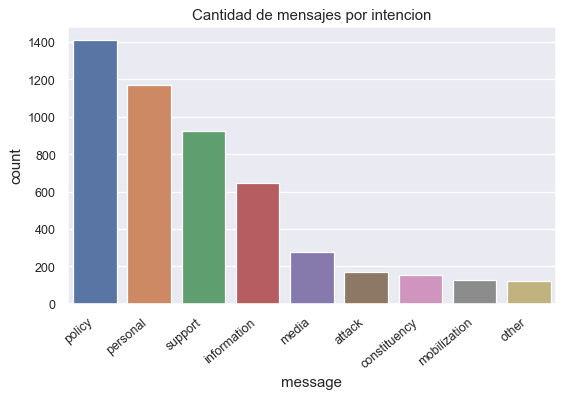

In [97]:
political_posts['message'].value_counts()
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
ax = sns.countplot(data = political_posts, x = 'message',
              order = political_posts['message'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
sns.set(rc={"figure.figsize":(5, 2)})
ax.set_title('Cantidad de mensajes por intencion')
plt.show()

Podemos observar que no hay una proporción similar de cada tipo de publicación, sino que hay mas de policy, seguido por personal, y tercero support.

### Clasificación de tipos de publicaciones según la audiencia a la que apunta

In [79]:
segun_audiencia = pd.crosstab(political_posts['message'],political_posts['audience']).apply(lambda x: x/x.sum()*100)
segun_audiencia

audience,constituency,national
message,,
attack,0.583090,4.180307
constituency,13.605442,0.302191
information,20.408163,11.004785
media,6.122449,5.389071
mobilization,4.081633,2.190884
other,1.360544,2.694535
personal,31.098154,21.405188
policy,15.257532,31.578947
support,7.482993,21.254092


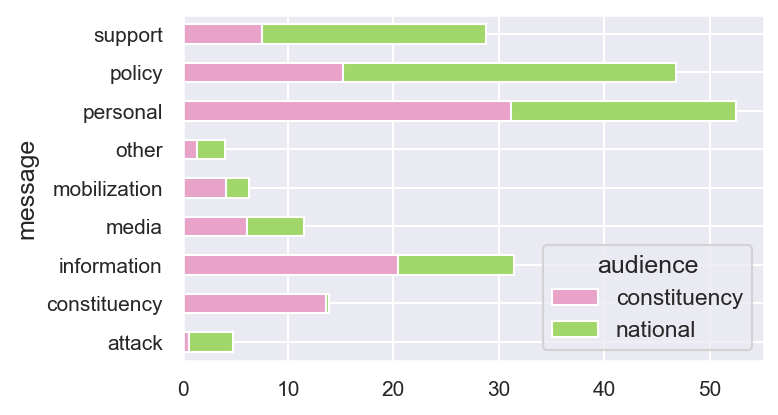

In [80]:
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
segun_audiencia[['constituency','national']].plot(kind ='barh', stacked=True,color = ("#e9a3c9", "#a1d76a"))

plt.show()

***


In [81]:
political_posts_attack = political_posts[political_posts['message'] == "attack"]
political_posts_support = political_posts[political_posts['message']=="support"]
political_posts_policy = political_posts[political_posts['message']=="policy"]
political_posts_information = political_posts[political_posts['message']=="information"]
political_posts_mobilization = political_posts[political_posts['message']=="mobilization"]
political_posts_personal = political_posts[political_posts['message']=="personal"]
political_posts_constituency = political_posts[political_posts['message']=="constituency"]
political_posts_media = political_posts[political_posts['message']=="media"]
political_posts_other = political_posts[political_posts['message']=="other"]

### De donde salieron las publicaciones segun la intencion de las mimsas

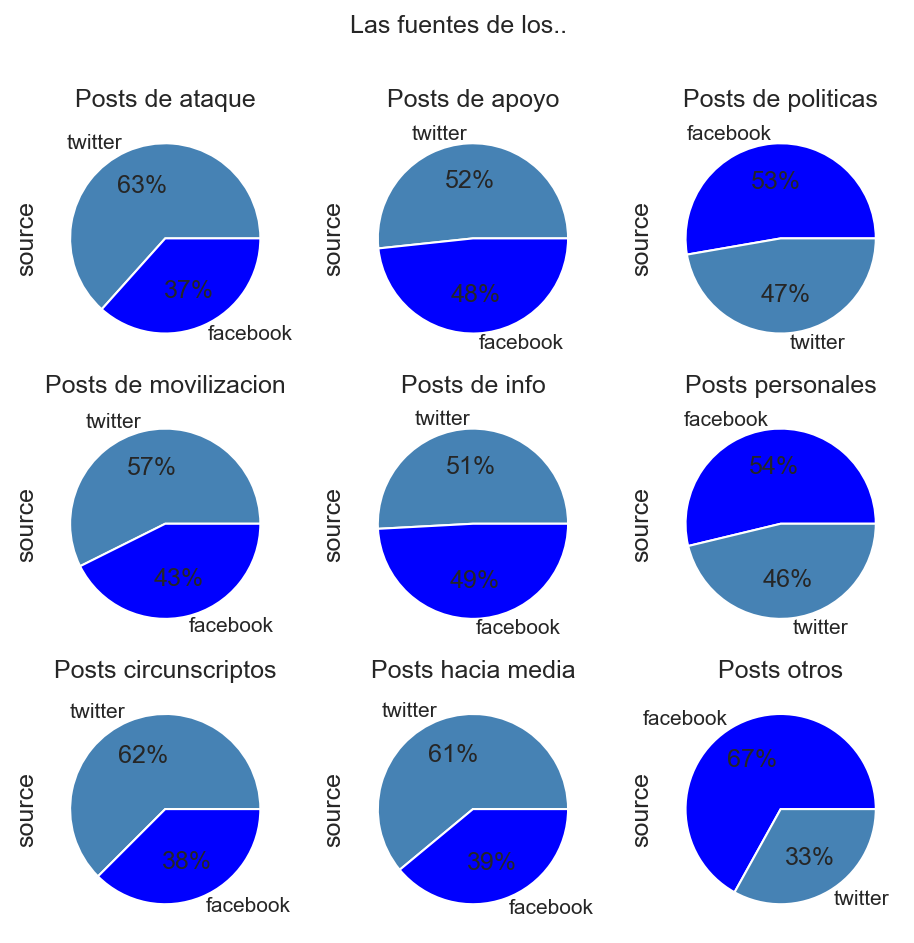

In [82]:
plt.rcParams.update({'figure.figsize':(7.5,7), 'figure.dpi':150})
fig, axes = plt.subplots(nrows=3, ncols=3)
political_posts_attack.source.value_counts().plot(ax=axes[0,0], kind ='pie', title = 'Posts de ataque',autopct='%1.0f%%', colors = ['steelblue', 'blue'])
political_posts_support.source.value_counts().plot(ax=axes[0,1],kind ='pie', title = 'Posts de apoyo',autopct='%1.0f%%', colors = ['steelblue', 'blue'])
political_posts_policy.source.value_counts().plot(ax=axes[0,2],kind ='pie', title = 'Posts de politicas',autopct='%1.0f%%', colors = ['blue', 'steelblue'])
political_posts_mobilization.source.value_counts().plot(ax=axes[1,0],kind ='pie', title = 'Posts de movilizacion',autopct='%1.0f%%', colors = ['steelblue', 'blue'])
political_posts_information.source.value_counts().plot(ax=axes[1,1],kind ='pie', title = 'Posts de info',autopct='%1.0f%%', colors = ['steelblue', 'blue'])
political_posts_personal.source.value_counts().plot(ax=axes[1,2],kind ='pie', title = 'Posts personales',autopct='%1.0f%%', colors = [ 'blue', 'steelblue',])
political_posts_constituency.source.value_counts().plot(ax=axes[2,0],kind ='pie', title = 'Posts circunscriptos',autopct='%1.0f%%', colors = ['steelblue', 'blue'])
political_posts_media.source.value_counts().plot(ax=axes[2,1],kind ='pie', title = 'Posts hacia media',autopct='%1.0f%%', colors = ['steelblue', 'blue'])
political_posts_other.source.value_counts().plot(ax=axes[2,2],kind ='pie', title = 'Posts otros',autopct='%1.0f%%', colors = [ 'blue', 'steelblue'])
fig.suptitle('Las fuentes de los..', fontsize=12)
plt.show()

## Nube de palabras: identificar las mas usadas

#### Attack

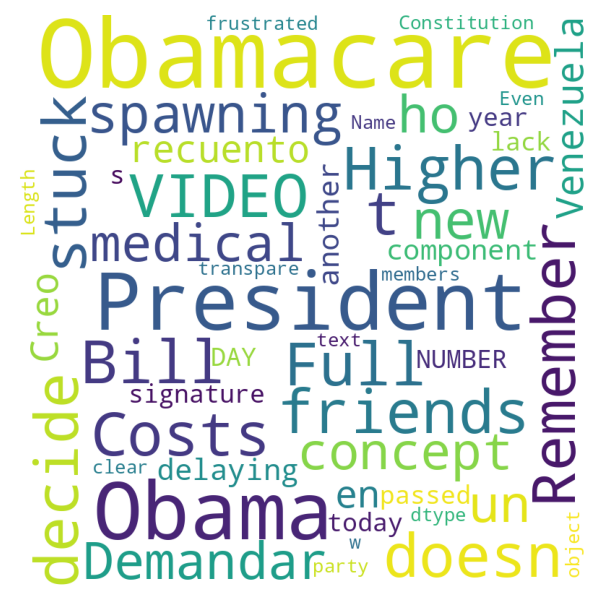

In [83]:
wordcloud = WordCloud(width = 800, height = 800,
            background_color ='white',
            min_font_size = 10).generate(str(political_posts_attack.text))

plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Las palabras más utilizadas en estas publicaciones, refieren a politicas o programas implementados durante la presidencia corriente (de Obama) y el nombre del dirigente es mencionado repetidas veces. Y también refieren a problemas o cuestiones del momento.
Algunas palabras que aparecen con ciertas connotaciones negativas son: costs, higher, stuck, spawning.
Es curioso que también aparece Venezuela, dentro de lso mensajes de ataque como critica (elemento que se podria transpolar a la situacion argentina)

### Support

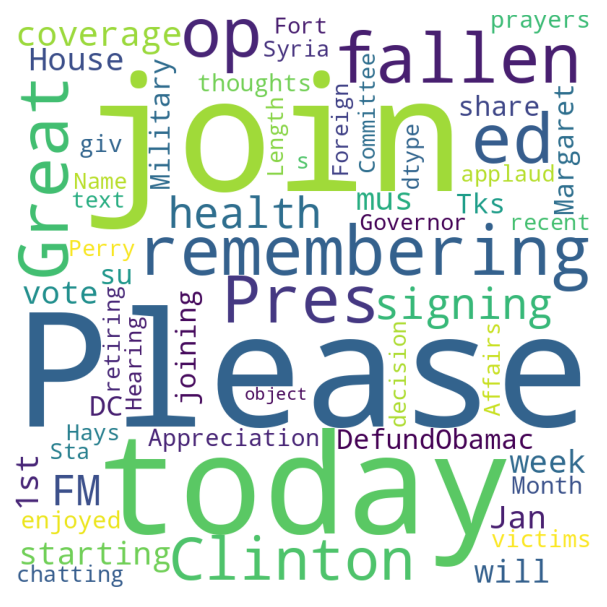

In [84]:
wordcloud = WordCloud(width = 800, height = 800,
            background_color ='white',
            min_font_size = 10).generate(str(political_posts_support.text))

plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

En los mensajes de apoyo a otros politicos, podemos encontrar palabaras con connotaciones mas positivas y con intenciones de "unir" o "amigar": join, please,  great, vote, share, applaud.
Y tambien en visperas de las eleccioes del 2016, vemos que aparece "Clinton", con referencia al apoyo a su candidatura en las proximas elecciones.

### Mobilization

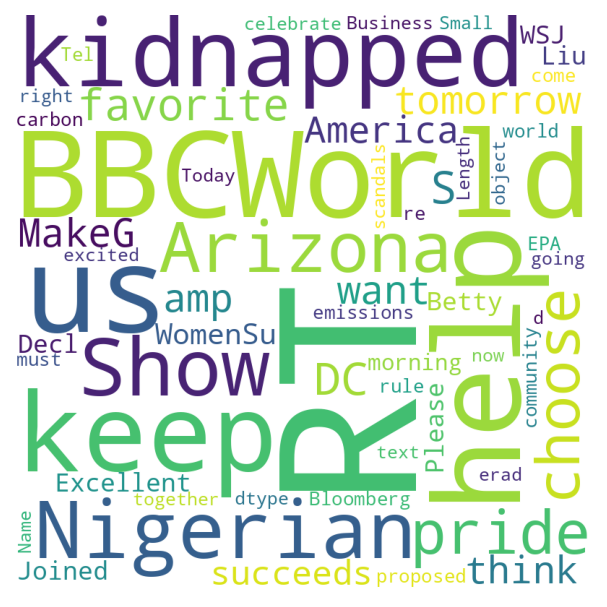

In [85]:
wordcloud = WordCloud(width = 800, height = 800,
            background_color ='white',
            min_font_size = 10).generate(str(political_posts_mobilization.text))

plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Las palabras que mas aparecen estan relacionadas a "llamados de ayuda" o "llamados a colaborar o a sumarse": help, rt, together, want, keep.
Y tambien aparecen situaciones que requieren el apoyo de la sociedad y de su movilizacion para que todos se enteren como la crisis social que sucedia en Nigeria, con los secuestros qeu pasaban y los atentados.
Ademas, aparece el nombre de un sitio de noticias conocido: BBCWorld

#### Policy

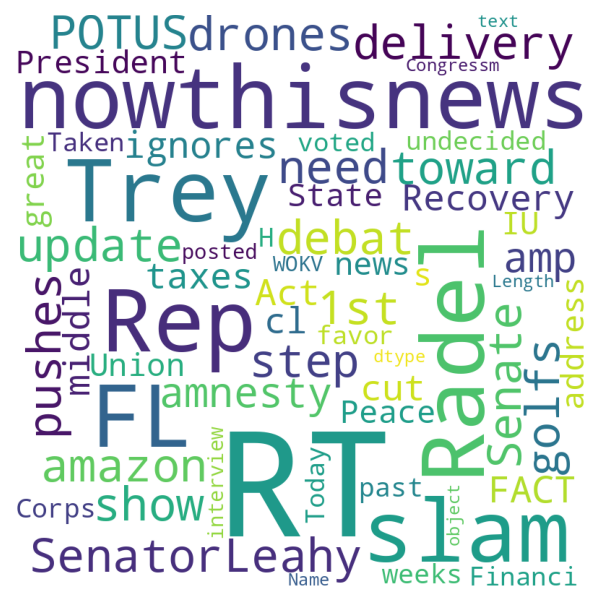

In [86]:
wordcloud = WordCloud(width = 800, height = 800,
            background_color ='white',
            min_font_size = 10).generate(str(political_posts_policy.text))

plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

En este caso aparecen bastantes nombres de politicos y se refiere a varias palabras relacionadas al sistema politico y al proceso de creacion de nuevas leyes

#### Personal

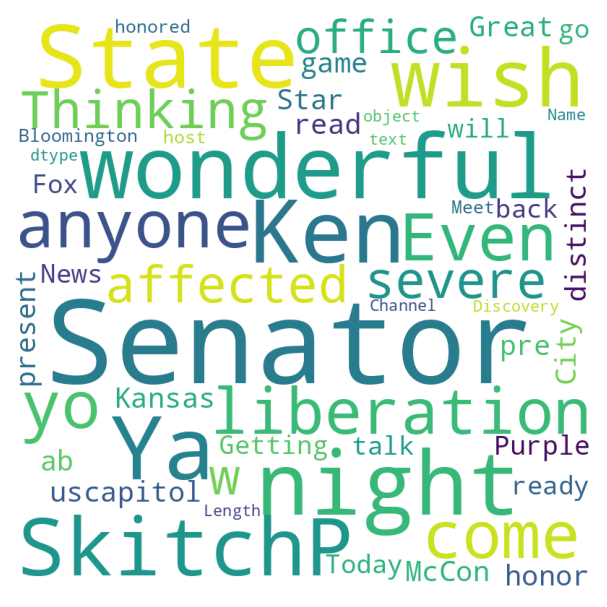

In [87]:
wordcloud = WordCloud(width = 800, height = 800,
            background_color ='white',
            min_font_size = 10).generate(str(political_posts_personal.text))

plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Information

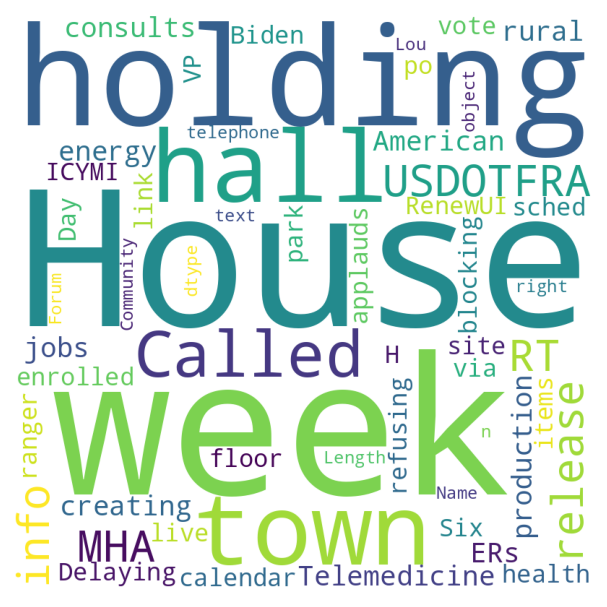

In [88]:
wordcloud = WordCloud(width = 800, height = 800,
            background_color ='white',
            min_font_size = 10).generate(str(political_posts_information.text))

plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

En los textos informativos, se utilizan palabras de "notica": week, info, release, hall + town. Tambien aparece el nombre de cuentas oficiales informativas del gobierno(USDOTFRA: Federal Railroad Administration)

#### Constituency

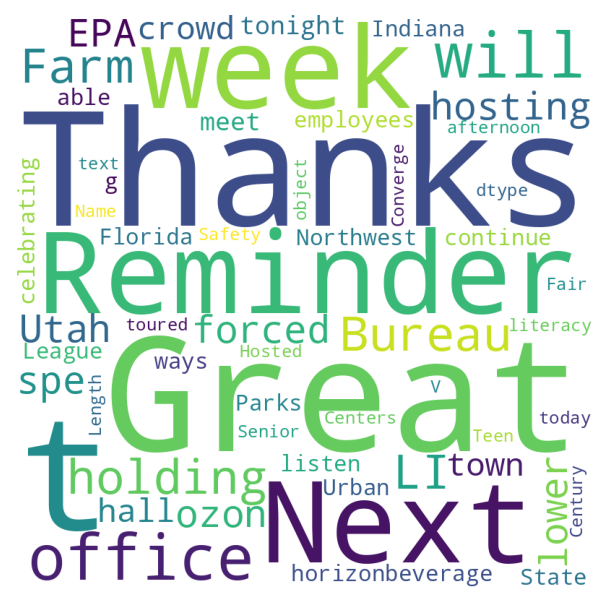

In [89]:
wordcloud = WordCloud(width = 800, height = 800,
            background_color ='white',
            min_font_size = 10).generate(str(political_posts_constituency.text))

plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Es mas dificil identificiar, ya que consituency refiere a mensajes con la intenncion de apuntar al ambito "local" del politico.
Ciertas palabras aprticulaes son: nombres de estados, farm, parks.

#### Media

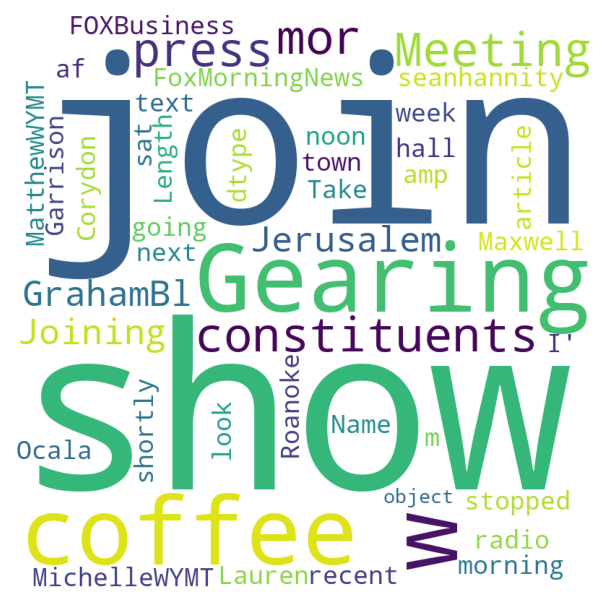

In [90]:
wordcloud = WordCloud(width = 800, height = 800,
            background_color ='white',
            min_font_size = 10).generate(str(political_posts_media.text))

plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Cuando lso mensajes implican una relacion con los medios de comunicacion, aprecen los nombres de lso portales de noticias, nombres de periodistas, y palabras como:show, coffee, radio, article, morning, shortly.

#### Other

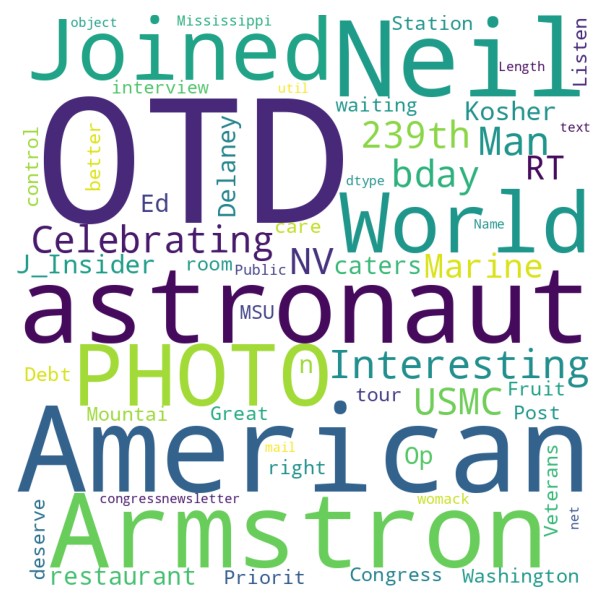

In [91]:
wordcloud = WordCloud(width = 800, height = 800,
            background_color ='white',
            min_font_size = 10).generate(str(political_posts_other.text))

plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Podemos ver como, se tratan temas varios, y temas que no implican una confrontacion o la neceisdad de apoyo o movilizacion. Palabras: American, celebraiting, bday, photo. Y tambien aparece el nombre de Neil Amstrong, y la palabra armstrong, que seguramente se debio a que la muestra de las publicaciones se habra tomado en alguna fecha en relacion con eso.

## Analizar el sesgo en relacion con los tipos de publicaciones

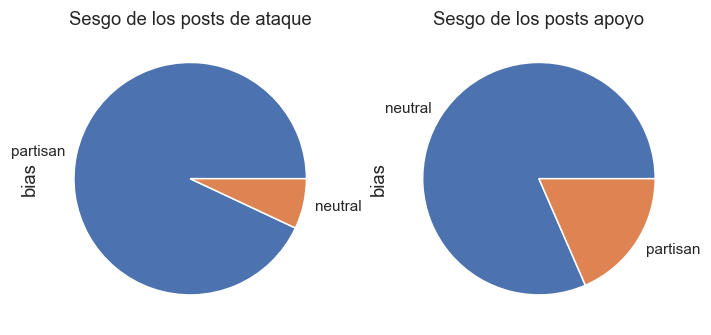

In [92]:
plt.rcParams.update({'figure.figsize':(7.5,7), 'figure.dpi':110})
fig, axes = plt.subplots(nrows=1, ncols=2)
political_posts_attack.bias.value_counts().plot(ax=axes[0], kind ='pie', title= 'Sesgo de los posts de ataque')
political_posts_support.bias.value_counts().plot(ax=axes[1],kind ='pie', title= 'Sesgo de los posts apoyo')
plt.show()

In [93]:
segun_sesgo = pd.crosstab(political_posts['message'],political_posts['bias']).apply(lambda x: x/x.sum()*100)
segun_sesgo

bias,neutral,partisan
message,,
attack,0.325291,12.204424
constituency,3.496883,1.754386
information,15.315804,6.254767
media,6.695581,2.288330
mobilization,2.439686,2.974828
other,3.171591,0.305111
personal,29.086473,7.398932
policy,19.110870,53.852021
support,20.357821,12.967201


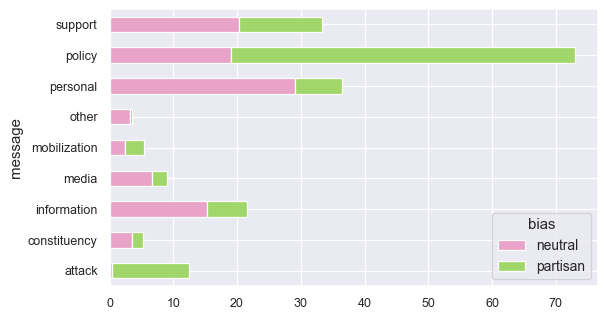

In [94]:
plt.rcParams.update({'figure.figsize':(7,4), 'figure.dpi':90})
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
segun_sesgo[['neutral','partisan']].plot(kind ='barh', stacked=True,color = ("#e9a3c9", "#a1d76a"))

plt.show()

### Ver si hay influencia por parte del: Estado

In [95]:
segun_estado = pd.crosstab(political_posts['estado'],political_posts['message']).apply(lambda x: x/x.sum()*100)
segun_estado

message,attack,constituency,information,media,mobilization,other,personal,policy,support
estado,,,,,,,,,
Alabama,0.581395,2.631579,1.854714,2.888087,1.550388,3.305785,1.538462,1.204819,1.194354
Alaska,0.000000,0.000000,0.309119,0.361011,0.000000,0.000000,0.683761,0.779589,0.434311
Arizona,3.488372,2.631579,4.018547,3.249097,1.550388,12.396694,2.222222,2.197023,2.714441
Arkansas,0.000000,2.631579,2.163833,2.527076,1.550388,2.479339,1.709402,1.063076,2.062975
California,11.046512,7.236842,9.582689,6.137184,10.077519,13.223140,11.111111,8.788094,10.206298
Colorado,1.162791,0.657895,2.163833,1.444043,0.000000,0.826446,1.367521,1.417434,1.520087
Connecticut,0.000000,1.315789,1.391036,0.722022,0.775194,1.652893,2.136752,1.700921,1.954397
Delaware,0.581395,0.000000,0.154560,0.722022,0.000000,0.000000,1.025641,0.496102,0.434311
District of Columbia,0.000000,0.000000,0.154560,0.000000,0.000000,0.000000,0.085470,0.000000,0.108578


In [96]:
segun_estado[segun_estado.attack == max(segun_estado.attack)]

message,attack,constituency,information,media,mobilization,other,personal,policy,support
estado,,,,,,,,,
Texas,13.372093,7.894737,10.664606,9.386282,9.302326,6.61157,10.34188,10.630758,7.926167


In [98]:
estado_mensaje = pd.crosstab(political_posts['message'],political_posts['estado']).apply(lambda x: x/x.sum()*100)
estado_mensaje

estado,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
message,,,,,,,,,,,,,,,,,,,,,
attack,1.298701,0.000000,4.166667,0.000000,3.909465,2.777778,0.000000,3.703704,0.000000,3.020134,...,5.555556,3.571429,4.655870,5.263158,1.785714,0.826446,1.176471,3.773585,2.898551,0.000000
constituency,5.194805,0.000000,2.777778,4.761905,2.263374,1.388889,2.409639,0.000000,0.000000,3.355705,...,16.666667,3.571429,2.429150,5.263158,0.000000,0.000000,3.529412,0.000000,2.898551,4.761905
information,15.584416,7.692308,18.055556,16.666667,12.757202,19.444444,10.843373,3.703704,33.333333,7.382550,...,22.222222,8.035714,13.967611,13.157895,10.714286,17.355372,10.588235,16.981132,8.695652,0.000000
media,10.389610,3.846154,6.250000,8.333333,3.497942,5.555556,2.409639,7.407407,0.000000,6.040268,...,0.000000,8.035714,5.263158,2.631579,8.928571,11.570248,2.352941,7.547170,7.246377,9.523810
mobilization,2.597403,0.000000,1.388889,2.380952,2.674897,0.000000,1.204819,0.000000,0.000000,3.691275,...,0.000000,4.464286,2.429150,5.263158,5.357143,2.479339,4.705882,0.000000,2.898551,0.000000
other,5.194805,0.000000,10.416667,3.571429,3.292181,1.388889,2.409639,0.000000,0.000000,1.342282,...,5.555556,1.785714,1.619433,2.631579,1.785714,0.826446,0.000000,1.886792,1.449275,0.000000
personal,23.376623,30.769231,18.055556,23.809524,26.748971,22.222222,30.120482,44.444444,33.333333,23.825503,...,22.222222,17.857143,24.493927,15.789474,16.071429,24.793388,18.823529,18.867925,8.695652,19.047619
policy,22.077922,42.307692,21.527778,17.857143,25.514403,27.777778,28.915663,25.925926,0.000000,30.536913,...,11.111111,33.035714,30.364372,28.947368,39.285714,23.140496,29.411765,26.415094,34.782609,61.904762
support,14.285714,15.384615,17.361111,22.619048,19.341564,19.444444,21.686747,14.814815,33.333333,20.805369,...,16.666667,19.642857,14.777328,21.052632,16.071429,19.008264,29.411765,24.528302,30.434783,4.761905


No encuentro relación fuerte, además de que no sabemos si las muestra se tomó de forma representativa y/o proporcional

#### Ver si hay influencia por parte del:Idioma

In [99]:
español_mensaje = posts_español.groupby(['language_name', 'message']).agg(
    cantidad_de_posts =  ('unit_id', 'count'))
español_mensaje

cantidad_de_posts
language_name       message                        
Spanish , Castilian attack                        1
                    constituency                  1
                    information                   4
                    media                         6
                    other                         3
                    personal                      6
                    policy                        9
                    support                       7

In [100]:
idiomas_mensaje = political_posts.groupby(['language_name', 'message']).agg(
    cantidad_de_posts =  ('unit_id', 'count')).reset_index()
idiomas_mensaje

,language_name,message,cantidad_de_posts
0,Desconocido,information,4
1,Desconocido,media,1
2,Desconocido,other,1
3,Desconocido,personal,1
4,Desconocido,policy,3
5,Desconocido,support,1
6,English,attack,171
7,English,constituency,151
8,English,information,639
9,English,media,270


In [101]:
idiomas_mensaje.pivot_table( values='cantidad_de_posts', index=['message'],columns=['language_name']).apply(lambda x: x/x.sum() * 100)

language_name,Desconocido,English,"Spanish , Castilian"
message,,,
attack,NaN,3.453150,2.702703
constituency,NaN,3.049273,2.702703
information,36.363636,12.903877,10.810811
media,9.090909,5.452342,16.216216
mobilization,NaN,2.605008,NaN
other,9.090909,2.362682,8.108108
personal,9.090909,23.485460,16.216216
policy,27.272727,28.251212,24.324324
support,9.090909,18.436995,18.918919


Por pate del idioma, tampoco encuentro influencia, ya que parecen comportarse de manera similar

# 6- Creación de variables numéricas en relación a lo analizado antes (palabras que aparecen, y cantidad de veces que aparece algún caracter especial)

## Cantidad de arrobas
Para ver la mención de otras personas/usuarios

In [104]:
political_posts['cantidad_arrobas'] = political_posts.text.str.count("@")
political_posts.head()

,unit_id,last_judgment_date,audience,bias,message,politico_id,mensaje_id_sitio,source,text,cantidad_caracteres,usuario,cargo,estado,language_name,cantidad_arrobas
0,766192484,2015-08-04 21:17:00,national,partisan,policy,R000596,3.83249E+17,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...,93,Trey Radel,Representative,Florida,English,1
1,766192485,2015-08-04 21:20:00,national,partisan,attack,M000355,3.11208E+17,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...,85,Mitch McConnell,Senator,Kentucky,English,0
2,766192486,2015-08-04 21:14:00,national,neutral,support,S001180,3.39069E+17,twitter,Please join me today in remembering our fallen...,136,Kurt Schrader,Representative,Oregon,English,0
3,766192487,2015-08-04 21:08:00,national,neutral,policy,C000880,2.98528E+17,twitter,RT @SenatorLeahy: 1st step toward Senate debat...,122,Michael Crapo,Senator,Idaho,English,1
4,766192488,2015-08-04 21:26:00,national,partisan,policy,U000038,4.07643E+17,twitter,.@amazon delivery #drones show need to update ...,143,Mark Udall,Senator,Colorado,English,1


## Cantidad hashtags
Paar ver la posible influencia de la utilización de hashtag que quizás son tendencias o algo similar

In [105]:
political_posts['cantidad_hashtag'] = political_posts.text.str.count("#")
political_posts.head()

,unit_id,last_judgment_date,audience,bias,message,politico_id,mensaje_id_sitio,source,text,cantidad_caracteres,usuario,cargo,estado,language_name,cantidad_arrobas,cantidad_hashtag
0,766192484,2015-08-04 21:17:00,national,partisan,policy,R000596,3.83249E+17,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...,93,Trey Radel,Representative,Florida,English,1,3
1,766192485,2015-08-04 21:20:00,national,partisan,attack,M000355,3.11208E+17,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...,85,Mitch McConnell,Senator,Kentucky,English,0,1
2,766192486,2015-08-04 21:14:00,national,neutral,support,S001180,3.39069E+17,twitter,Please join me today in remembering our fallen...,136,Kurt Schrader,Representative,Oregon,English,0,0
3,766192487,2015-08-04 21:08:00,national,neutral,policy,C000880,2.98528E+17,twitter,RT @SenatorLeahy: 1st step toward Senate debat...,122,Michael Crapo,Senator,Idaho,English,1,1
4,766192488,2015-08-04 21:26:00,national,partisan,policy,U000038,4.07643E+17,twitter,.@amazon delivery #drones show need to update ...,143,Mark Udall,Senator,Colorado,English,1,4


## Tiene Obama
Relacionado a las palabras que aparecieron en la nube de palabras

In [106]:
political_posts['cantidad_obama'] = political_posts.text.str.count("[Oo]bama")
political_posts['tiene_obama'] = np.where(political_posts.cantidad_obama >0, 1, 0)
political_posts.drop(['cantidad_obama'], inplace=True, axis = 1)
political_posts.head()

,unit_id,last_judgment_date,audience,bias,message,politico_id,mensaje_id_sitio,source,text,cantidad_caracteres,usuario,cargo,estado,language_name,cantidad_arrobas,cantidad_hashtag,tiene_obama
0,766192484,2015-08-04 21:17:00,national,partisan,policy,R000596,3.83249E+17,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...,93,Trey Radel,Representative,Florida,English,1,3,1
1,766192485,2015-08-04 21:20:00,national,partisan,attack,M000355,3.11208E+17,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...,85,Mitch McConnell,Senator,Kentucky,English,0,1,1
2,766192486,2015-08-04 21:14:00,national,neutral,support,S001180,3.39069E+17,twitter,Please join me today in remembering our fallen...,136,Kurt Schrader,Representative,Oregon,English,0,0,0
3,766192487,2015-08-04 21:08:00,national,neutral,policy,C000880,2.98528E+17,twitter,RT @SenatorLeahy: 1st step toward Senate debat...,122,Michael Crapo,Senator,Idaho,English,1,1,0
4,766192488,2015-08-04 21:26:00,national,partisan,policy,U000038,4.07643E+17,twitter,.@amazon delivery #drones show need to update ...,143,Mark Udall,Senator,Colorado,English,1,4,0


## Tiene Obamacare
Relacionado a las palabras que aparecieron en la nube de palabras

In [107]:
political_posts['cantidad_obamacare'] = political_posts.text.str.count("[Oo]bamacare")
political_posts['tiene_obamacare'] = np.where(political_posts.cantidad_obamacare >0, 1, 0)
political_posts.drop(['cantidad_obamacare'], inplace=True, axis = 1)
political_posts.head()

,unit_id,last_judgment_date,audience,bias,message,politico_id,mensaje_id_sitio,source,text,cantidad_caracteres,usuario,cargo,estado,language_name,cantidad_arrobas,cantidad_hashtag,tiene_obama,tiene_obamacare
0,766192484,2015-08-04 21:17:00,national,partisan,policy,R000596,3.83249E+17,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...,93,Trey Radel,Representative,Florida,English,1,3,1,1
1,766192485,2015-08-04 21:20:00,national,partisan,attack,M000355,3.11208E+17,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...,85,Mitch McConnell,Senator,Kentucky,English,0,1,1,1
2,766192486,2015-08-04 21:14:00,national,neutral,support,S001180,3.39069E+17,twitter,Please join me today in remembering our fallen...,136,Kurt Schrader,Representative,Oregon,English,0,0,0,0
3,766192487,2015-08-04 21:08:00,national,neutral,policy,C000880,2.98528E+17,twitter,RT @SenatorLeahy: 1st step toward Senate debat...,122,Michael Crapo,Senator,Idaho,English,1,1,0,0
4,766192488,2015-08-04 21:26:00,national,partisan,policy,U000038,4.07643E+17,twitter,.@amazon delivery #drones show need to update ...,143,Mark Udall,Senator,Colorado,English,1,4,0,0


## Tiene costs
Relacionado a las palabras que aparecieron en la nube de palabras

In [108]:
political_posts['cantidad_costs'] = political_posts.text.str.count("[Cc]osts")
political_posts['tiene_costs'] = np.where(political_posts.cantidad_costs >0, 1, 0)
political_posts.drop(['cantidad_costs'], inplace=True, axis = 1)
political_posts.head()

,unit_id,last_judgment_date,audience,bias,message,politico_id,mensaje_id_sitio,source,text,cantidad_caracteres,usuario,cargo,estado,language_name,cantidad_arrobas,cantidad_hashtag,tiene_obama,tiene_obamacare,tiene_costs
0,766192484,2015-08-04 21:17:00,national,partisan,policy,R000596,3.83249E+17,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...,93,Trey Radel,Representative,Florida,English,1,3,1,1,0
1,766192485,2015-08-04 21:20:00,national,partisan,attack,M000355,3.11208E+17,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...,85,Mitch McConnell,Senator,Kentucky,English,0,1,1,1,1
2,766192486,2015-08-04 21:14:00,national,neutral,support,S001180,3.39069E+17,twitter,Please join me today in remembering our fallen...,136,Kurt Schrader,Representative,Oregon,English,0,0,0,0,0
3,766192487,2015-08-04 21:08:00,national,neutral,policy,C000880,2.98528E+17,twitter,RT @SenatorLeahy: 1st step toward Senate debat...,122,Michael Crapo,Senator,Idaho,English,1,1,0,0,0
4,766192488,2015-08-04 21:26:00,national,partisan,policy,U000038,4.07643E+17,twitter,.@amazon delivery #drones show need to update ...,143,Mark Udall,Senator,Colorado,English,1,4,0,0,0


## Tiene Venezuela
Relacionado a las palabras que aparecieron en la nube de palabras

In [109]:
political_posts['cantidad_venezuela'] = political_posts.text.str.count("[Vv]enezuela")
political_posts['tiene_venezuela'] = np.where(political_posts.cantidad_venezuela >0, 1, 0)
political_posts.drop(['cantidad_venezuela'], inplace=True, axis = 1)
political_posts.head()

,unit_id,last_judgment_date,audience,bias,message,politico_id,mensaje_id_sitio,source,text,cantidad_caracteres,usuario,cargo,estado,language_name,cantidad_arrobas,cantidad_hashtag,tiene_obama,tiene_obamacare,tiene_costs,tiene_venezuela
0,766192484,2015-08-04 21:17:00,national,partisan,policy,R000596,3.83249E+17,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...,93,Trey Radel,Representative,Florida,English,1,3,1,1,0,0
1,766192485,2015-08-04 21:20:00,national,partisan,attack,M000355,3.11208E+17,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...,85,Mitch McConnell,Senator,Kentucky,English,0,1,1,1,1,0
2,766192486,2015-08-04 21:14:00,national,neutral,support,S001180,3.39069E+17,twitter,Please join me today in remembering our fallen...,136,Kurt Schrader,Representative,Oregon,English,0,0,0,0,0,0
3,766192487,2015-08-04 21:08:00,national,neutral,policy,C000880,2.98528E+17,twitter,RT @SenatorLeahy: 1st step toward Senate debat...,122,Michael Crapo,Senator,Idaho,English,1,1,0,0,0,0
4,766192488,2015-08-04 21:26:00,national,partisan,policy,U000038,4.07643E+17,twitter,.@amazon delivery #drones show need to update ...,143,Mark Udall,Senator,Colorado,English,1,4,0,0,0,0


## Tiene Demandar
Relacionado a las palabras que aparecieron en la nube de palabras

In [110]:
political_posts['cantidad_demandar'] = political_posts.text.str.count("[Dd]emandar")
political_posts['tiene_demandar'] = np.where(political_posts.cantidad_demandar >0, 1, 0)
political_posts.drop(['cantidad_demandar'], inplace=True, axis = 1)
political_posts.head()

,unit_id,last_judgment_date,audience,bias,message,politico_id,mensaje_id_sitio,source,text,cantidad_caracteres,...,cargo,estado,language_name,cantidad_arrobas,cantidad_hashtag,tiene_obama,tiene_obamacare,tiene_costs,tiene_venezuela,tiene_demandar
0,766192484,2015-08-04 21:17:00,national,partisan,policy,R000596,3.83249E+17,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...,93,...,Representative,Florida,English,1,3,1,1,0,0,0
1,766192485,2015-08-04 21:20:00,national,partisan,attack,M000355,3.11208E+17,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...,85,...,Senator,Kentucky,English,0,1,1,1,1,0,0
2,766192486,2015-08-04 21:14:00,national,neutral,support,S001180,3.39069E+17,twitter,Please join me today in remembering our fallen...,136,...,Representative,Oregon,English,0,0,0,0,0,0,0
3,766192487,2015-08-04 21:08:00,national,neutral,policy,C000880,2.98528E+17,twitter,RT @SenatorLeahy: 1st step toward Senate debat...,122,...,Senator,Idaho,English,1,1,0,0,0,0,0
4,766192488,2015-08-04 21:26:00,national,partisan,policy,U000038,4.07643E+17,twitter,.@amazon delivery #drones show need to update ...,143,...,Senator,Colorado,English,1,4,0,0,0,0,0


## Tiene Remember
Relacionado a las palabras que aparecieron en la nube de palabras

In [111]:
political_posts['cantidad_remember'] = political_posts.text.str.count("[Rr]emember")
political_posts['tiene_remember'] = np.where(political_posts.cantidad_remember >0, 1, 0)
political_posts.drop(['cantidad_remember'], inplace=True, axis = 1)
political_posts.head()

,unit_id,last_judgment_date,audience,bias,message,politico_id,mensaje_id_sitio,source,text,cantidad_caracteres,...,estado,language_name,cantidad_arrobas,cantidad_hashtag,tiene_obama,tiene_obamacare,tiene_costs,tiene_venezuela,tiene_demandar,tiene_remember
0,766192484,2015-08-04 21:17:00,national,partisan,policy,R000596,3.83249E+17,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...,93,...,Florida,English,1,3,1,1,0,0,0,0
1,766192485,2015-08-04 21:20:00,national,partisan,attack,M000355,3.11208E+17,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...,85,...,Kentucky,English,0,1,1,1,1,0,0,0
2,766192486,2015-08-04 21:14:00,national,neutral,support,S001180,3.39069E+17,twitter,Please join me today in remembering our fallen...,136,...,Oregon,English,0,0,0,0,0,0,0,1
3,766192487,2015-08-04 21:08:00,national,neutral,policy,C000880,2.98528E+17,twitter,RT @SenatorLeahy: 1st step toward Senate debat...,122,...,Idaho,English,1,1,0,0,0,0,0,0
4,766192488,2015-08-04 21:26:00,national,partisan,policy,U000038,4.07643E+17,twitter,.@amazon delivery #drones show need to update ...,143,...,Colorado,English,1,4,0,0,0,0,0,0


## Tiene Stuck
Relacionado a las palabras que aparecieron en la nube de palabras

In [112]:
political_posts['cantidad_stuck'] = political_posts.text.str.count("[Ss]tuck")
political_posts['tiene_stuck'] = np.where(political_posts.cantidad_stuck >0, 1, 0)
political_posts.drop(['cantidad_stuck'], inplace=True, axis = 1)
political_posts.head()

,unit_id,last_judgment_date,audience,bias,message,politico_id,mensaje_id_sitio,source,text,cantidad_caracteres,...,language_name,cantidad_arrobas,cantidad_hashtag,tiene_obama,tiene_obamacare,tiene_costs,tiene_venezuela,tiene_demandar,tiene_remember,tiene_stuck
0,766192484,2015-08-04 21:17:00,national,partisan,policy,R000596,3.83249E+17,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...,93,...,English,1,3,1,1,0,0,0,0,0
1,766192485,2015-08-04 21:20:00,national,partisan,attack,M000355,3.11208E+17,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...,85,...,English,0,1,1,1,1,0,0,0,0
2,766192486,2015-08-04 21:14:00,national,neutral,support,S001180,3.39069E+17,twitter,Please join me today in remembering our fallen...,136,...,English,0,0,0,0,0,0,0,1,0
3,766192487,2015-08-04 21:08:00,national,neutral,policy,C000880,2.98528E+17,twitter,RT @SenatorLeahy: 1st step toward Senate debat...,122,...,English,1,1,0,0,0,0,0,0,0
4,766192488,2015-08-04 21:26:00,national,partisan,policy,U000038,4.07643E+17,twitter,.@amazon delivery #drones show need to update ...,143,...,English,1,4,0,0,0,0,0,0,0


## Tiene Higher
Relacionado a las palabras que aparecieron en la nube de palabras

In [113]:
political_posts['cantidad_higher'] = political_posts.text.str.count("[Hh]igher")
political_posts['tiene_higher'] = np.where(political_posts.cantidad_higher >0, 1, 0)
political_posts.drop(['cantidad_higher'], inplace=True, axis = 1)
political_posts.head()

,unit_id,last_judgment_date,audience,bias,message,politico_id,mensaje_id_sitio,source,text,cantidad_caracteres,...,cantidad_arrobas,cantidad_hashtag,tiene_obama,tiene_obamacare,tiene_costs,tiene_venezuela,tiene_demandar,tiene_remember,tiene_stuck,tiene_higher
0,766192484,2015-08-04 21:17:00,national,partisan,policy,R000596,3.83249E+17,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...,93,...,1,3,1,1,0,0,0,0,0,0
1,766192485,2015-08-04 21:20:00,national,partisan,attack,M000355,3.11208E+17,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...,85,...,0,1,1,1,1,0,0,0,0,1
2,766192486,2015-08-04 21:14:00,national,neutral,support,S001180,3.39069E+17,twitter,Please join me today in remembering our fallen...,136,...,0,0,0,0,0,0,0,1,0,0
3,766192487,2015-08-04 21:08:00,national,neutral,policy,C000880,2.98528E+17,twitter,RT @SenatorLeahy: 1st step toward Senate debat...,122,...,1,1,0,0,0,0,0,0,0,0
4,766192488,2015-08-04 21:26:00,national,partisan,policy,U000038,4.07643E+17,twitter,.@amazon delivery #drones show need to update ...,143,...,1,4,0,0,0,0,0,0,0,0


## Tiene Spawning
Relacionado a las palabras que aparecieron en la nube de palabras

In [114]:
political_posts['cantidad_spawning'] = political_posts.text.str.count("[Ss]pawning")
political_posts['tiene_spawning'] = np.where(political_posts.cantidad_spawning >0, 1, 0)
political_posts.drop(['cantidad_spawning'], inplace=True, axis = 1)
political_posts.head()

,unit_id,last_judgment_date,audience,bias,message,politico_id,mensaje_id_sitio,source,text,cantidad_caracteres,...,cantidad_hashtag,tiene_obama,tiene_obamacare,tiene_costs,tiene_venezuela,tiene_demandar,tiene_remember,tiene_stuck,tiene_higher,tiene_spawning
0,766192484,2015-08-04 21:17:00,national,partisan,policy,R000596,3.83249E+17,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...,93,...,3,1,1,0,0,0,0,0,0,0
1,766192485,2015-08-04 21:20:00,national,partisan,attack,M000355,3.11208E+17,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...,85,...,1,1,1,1,0,0,0,0,1,0
2,766192486,2015-08-04 21:14:00,national,neutral,support,S001180,3.39069E+17,twitter,Please join me today in remembering our fallen...,136,...,0,0,0,0,0,0,1,0,0,0
3,766192487,2015-08-04 21:08:00,national,neutral,policy,C000880,2.98528E+17,twitter,RT @SenatorLeahy: 1st step toward Senate debat...,122,...,1,0,0,0,0,0,0,0,0,0
4,766192488,2015-08-04 21:26:00,national,partisan,policy,U000038,4.07643E+17,twitter,.@amazon delivery #drones show need to update ...,143,...,4,0,0,0,0,0,0,0,0,0


## Tiene Please
Relacionado a las palabras que aparecieron en la nube de palabras

In [115]:
political_posts['cantidad_please'] = political_posts.text.str.count("[Pp]lease")
political_posts['tiene_please'] = np.where(political_posts.cantidad_please >0, 1, 0)
political_posts.drop(['cantidad_please'], inplace=True, axis = 1)
political_posts.head()

,unit_id,last_judgment_date,audience,bias,message,politico_id,mensaje_id_sitio,source,text,cantidad_caracteres,...,tiene_obama,tiene_obamacare,tiene_costs,tiene_venezuela,tiene_demandar,tiene_remember,tiene_stuck,tiene_higher,tiene_spawning,tiene_please
0,766192484,2015-08-04 21:17:00,national,partisan,policy,R000596,3.83249E+17,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...,93,...,1,1,0,0,0,0,0,0,0,0
1,766192485,2015-08-04 21:20:00,national,partisan,attack,M000355,3.11208E+17,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...,85,...,1,1,1,0,0,0,0,1,0,0
2,766192486,2015-08-04 21:14:00,national,neutral,support,S001180,3.39069E+17,twitter,Please join me today in remembering our fallen...,136,...,0,0,0,0,0,1,0,0,0,1
3,766192487,2015-08-04 21:08:00,national,neutral,policy,C000880,2.98528E+17,twitter,RT @SenatorLeahy: 1st step toward Senate debat...,122,...,0,0,0,0,0,0,0,0,0,0
4,766192488,2015-08-04 21:26:00,national,partisan,policy,U000038,4.07643E+17,twitter,.@amazon delivery #drones show need to update ...,143,...,0,0,0,0,0,0,0,0,0,0


## Tiene Join
Relacionado a las palabras que aparecieron en la nube de palabras

In [116]:
political_posts['cantidad_join'] = political_posts.text.str.count("[Jj]oin")
political_posts['tiene_join'] = np.where(political_posts.cantidad_join >0, 1, 0)
political_posts.drop(['cantidad_join'], inplace=True, axis = 1)
political_posts.head()

,unit_id,last_judgment_date,audience,bias,message,politico_id,mensaje_id_sitio,source,text,cantidad_caracteres,...,tiene_obamacare,tiene_costs,tiene_venezuela,tiene_demandar,tiene_remember,tiene_stuck,tiene_higher,tiene_spawning,tiene_please,tiene_join
0,766192484,2015-08-04 21:17:00,national,partisan,policy,R000596,3.83249E+17,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...,93,...,1,0,0,0,0,0,0,0,0,0
1,766192485,2015-08-04 21:20:00,national,partisan,attack,M000355,3.11208E+17,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...,85,...,1,1,0,0,0,0,1,0,0,0
2,766192486,2015-08-04 21:14:00,national,neutral,support,S001180,3.39069E+17,twitter,Please join me today in remembering our fallen...,136,...,0,0,0,0,1,0,0,0,1,1
3,766192487,2015-08-04 21:08:00,national,neutral,policy,C000880,2.98528E+17,twitter,RT @SenatorLeahy: 1st step toward Senate debat...,122,...,0,0,0,0,0,0,0,0,0,0
4,766192488,2015-08-04 21:26:00,national,partisan,policy,U000038,4.07643E+17,twitter,.@amazon delivery #drones show need to update ...,143,...,0,0,0,0,0,0,0,0,0,0


## Tiene Great
Relacionado a las palabras que aparecieron en la nube de palabras

In [117]:
political_posts['cantidad_great'] = political_posts.text.str.count("[Gg]reat")
political_posts['tiene_great'] = np.where(political_posts.cantidad_great >0, 1, 0)
political_posts.drop(['cantidad_great'], inplace=True, axis = 1)
political_posts.head()

,unit_id,last_judgment_date,audience,bias,message,politico_id,mensaje_id_sitio,source,text,cantidad_caracteres,...,tiene_costs,tiene_venezuela,tiene_demandar,tiene_remember,tiene_stuck,tiene_higher,tiene_spawning,tiene_please,tiene_join,tiene_great
0,766192484,2015-08-04 21:17:00,national,partisan,policy,R000596,3.83249E+17,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...,93,...,0,0,0,0,0,0,0,0,0,0
1,766192485,2015-08-04 21:20:00,national,partisan,attack,M000355,3.11208E+17,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...,85,...,1,0,0,0,0,1,0,0,0,0
2,766192486,2015-08-04 21:14:00,national,neutral,support,S001180,3.39069E+17,twitter,Please join me today in remembering our fallen...,136,...,0,0,0,1,0,0,0,1,1,0
3,766192487,2015-08-04 21:08:00,national,neutral,policy,C000880,2.98528E+17,twitter,RT @SenatorLeahy: 1st step toward Senate debat...,122,...,0,0,0,0,0,0,0,0,0,0
4,766192488,2015-08-04 21:26:00,national,partisan,policy,U000038,4.07643E+17,twitter,.@amazon delivery #drones show need to update ...,143,...,0,0,0,0,0,0,0,0,0,0


## Tiene Vote
Relacionado a las palabras que aparecieron en la nube de palabras

In [118]:
political_posts['cantidad_vote'] = political_posts.text.str.count("[Vv]ote")
political_posts['tiene_vote'] = np.where(political_posts.cantidad_vote >0, 1, 0)
political_posts.drop(['cantidad_vote'], inplace=True, axis = 1)
political_posts.head()

,unit_id,last_judgment_date,audience,bias,message,politico_id,mensaje_id_sitio,source,text,cantidad_caracteres,...,tiene_venezuela,tiene_demandar,tiene_remember,tiene_stuck,tiene_higher,tiene_spawning,tiene_please,tiene_join,tiene_great,tiene_vote
0,766192484,2015-08-04 21:17:00,national,partisan,policy,R000596,3.83249E+17,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...,93,...,0,0,0,0,0,0,0,0,0,0
1,766192485,2015-08-04 21:20:00,national,partisan,attack,M000355,3.11208E+17,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...,85,...,0,0,0,0,1,0,0,0,0,0
2,766192486,2015-08-04 21:14:00,national,neutral,support,S001180,3.39069E+17,twitter,Please join me today in remembering our fallen...,136,...,0,0,1,0,0,0,1,1,0,0
3,766192487,2015-08-04 21:08:00,national,neutral,policy,C000880,2.98528E+17,twitter,RT @SenatorLeahy: 1st step toward Senate debat...,122,...,0,0,0,0,0,0,0,0,0,1
4,766192488,2015-08-04 21:26:00,national,partisan,policy,U000038,4.07643E+17,twitter,.@amazon delivery #drones show need to update ...,143,...,0,0,0,0,0,0,0,0,0,0


## Tiene Share
Relacionado a las palabras que aparecieron en la nube de palabras

In [119]:
political_posts['cantidad_share'] = political_posts.text.str.count("[Ss]hare")
political_posts['tiene_share'] = np.where(political_posts.cantidad_share >0, 1, 0)
political_posts.drop(['cantidad_share'], inplace=True, axis = 1)
political_posts.head()

,unit_id,last_judgment_date,audience,bias,message,politico_id,mensaje_id_sitio,source,text,cantidad_caracteres,...,tiene_demandar,tiene_remember,tiene_stuck,tiene_higher,tiene_spawning,tiene_please,tiene_join,tiene_great,tiene_vote,tiene_share
0,766192484,2015-08-04 21:17:00,national,partisan,policy,R000596,3.83249E+17,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...,93,...,0,0,0,0,0,0,0,0,0,0
1,766192485,2015-08-04 21:20:00,national,partisan,attack,M000355,3.11208E+17,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...,85,...,0,0,0,1,0,0,0,0,0,0
2,766192486,2015-08-04 21:14:00,national,neutral,support,S001180,3.39069E+17,twitter,Please join me today in remembering our fallen...,136,...,0,1,0,0,0,1,1,0,0,0
3,766192487,2015-08-04 21:08:00,national,neutral,policy,C000880,2.98528E+17,twitter,RT @SenatorLeahy: 1st step toward Senate debat...,122,...,0,0,0,0,0,0,0,0,1,0
4,766192488,2015-08-04 21:26:00,national,partisan,policy,U000038,4.07643E+17,twitter,.@amazon delivery #drones show need to update ...,143,...,0,0,0,0,0,0,0,0,0,0


## Tiene Applaud
Relacionado a las palabras que aparecieron en la nube de palabras

In [120]:
political_posts['cantidad_applaud'] = political_posts.text.str.count("[Aa]pplaud")
political_posts['tiene_applaud'] = np.where(political_posts.cantidad_applaud >0, 1, 0)
political_posts.drop(['cantidad_applaud'], inplace=True, axis = 1)
political_posts.head()

,unit_id,last_judgment_date,audience,bias,message,politico_id,mensaje_id_sitio,source,text,cantidad_caracteres,...,tiene_remember,tiene_stuck,tiene_higher,tiene_spawning,tiene_please,tiene_join,tiene_great,tiene_vote,tiene_share,tiene_applaud
0,766192484,2015-08-04 21:17:00,national,partisan,policy,R000596,3.83249E+17,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...,93,...,0,0,0,0,0,0,0,0,0,0
1,766192485,2015-08-04 21:20:00,national,partisan,attack,M000355,3.11208E+17,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...,85,...,0,0,1,0,0,0,0,0,0,0
2,766192486,2015-08-04 21:14:00,national,neutral,support,S001180,3.39069E+17,twitter,Please join me today in remembering our fallen...,136,...,1,0,0,0,1,1,0,0,0,0
3,766192487,2015-08-04 21:08:00,national,neutral,policy,C000880,2.98528E+17,twitter,RT @SenatorLeahy: 1st step toward Senate debat...,122,...,0,0,0,0,0,0,0,1,0,0
4,766192488,2015-08-04 21:26:00,national,partisan,policy,U000038,4.07643E+17,twitter,.@amazon delivery #drones show need to update ...,143,...,0,0,0,0,0,0,0,0,0,0


## Tiene Clinton
Relacionado a las palabras que aparecieron en la nube de palabras

In [121]:
political_posts['cantidad_clinton'] = political_posts.text.str.count("[Cc]linton")
political_posts['tiene_clinton'] = np.where(political_posts.cantidad_clinton >0, 1, 0)
political_posts.drop(['cantidad_clinton'], inplace=True, axis = 1)
political_posts.head()

,unit_id,last_judgment_date,audience,bias,message,politico_id,mensaje_id_sitio,source,text,cantidad_caracteres,...,tiene_stuck,tiene_higher,tiene_spawning,tiene_please,tiene_join,tiene_great,tiene_vote,tiene_share,tiene_applaud,tiene_clinton
0,766192484,2015-08-04 21:17:00,national,partisan,policy,R000596,3.83249E+17,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...,93,...,0,0,0,0,0,0,0,0,0,0
1,766192485,2015-08-04 21:20:00,national,partisan,attack,M000355,3.11208E+17,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...,85,...,0,1,0,0,0,0,0,0,0,0
2,766192486,2015-08-04 21:14:00,national,neutral,support,S001180,3.39069E+17,twitter,Please join me today in remembering our fallen...,136,...,0,0,0,1,1,0,0,0,0,0
3,766192487,2015-08-04 21:08:00,national,neutral,policy,C000880,2.98528E+17,twitter,RT @SenatorLeahy: 1st step toward Senate debat...,122,...,0,0,0,0,0,0,1,0,0,0
4,766192488,2015-08-04 21:26:00,national,partisan,policy,U000038,4.07643E+17,twitter,.@amazon delivery #drones show need to update ...,143,...,0,0,0,0,0,0,0,0,0,0


# 7- Me quedo con las columnas que considero relevantes y con los posts de ataque y apoyo, y guardo la tabla
Decidí quedarme con los de ataque y apoyo para tener un objetivo polarizado y "binario"

In [123]:
political_posts.columns

Index(['unit_id', 'last_judgment_date', 'audience', 'bias', 'message',
       'politico_id', 'mensaje_id_sitio', 'source', 'text',
       'cantidad_caracteres', 'usuario', 'cargo', 'estado', 'language_name',
       'cantidad_arrobas', 'cantidad_hashtag', 'tiene_obama',
       'tiene_obamacare', 'tiene_costs', 'tiene_venezuela', 'tiene_demandar',
       'tiene_remember', 'tiene_stuck', 'tiene_higher', 'tiene_spawning',
       'tiene_please', 'tiene_join', 'tiene_great', 'tiene_vote',
       'tiene_share', 'tiene_applaud', 'tiene_clinton'],
      dtype='object')

In [122]:
columnas = ['unit_id', 'audience', 'bias', 'message', 'source', 'cantidad_caracteres', 'cargo',
            'language_name', 'cantidad_arrobas', 'cantidad_hashtag', 'tiene_obama', 'tiene_obamacare', 'tiene_costs',
            'tiene_venezuela', 'tiene_demandar', 'tiene_remember', 'tiene_stuck', 'tiene_higher', 'tiene_spawning',
            'tiene_please', 'tiene_join', 'tiene_great', 'tiene_vote', 'tiene_share', 'tiene_applaud', 'tiene_clinton']
attack_suport = political_posts[(political_posts['message'] == 'attack') | (political_posts['message'] == 'support') ]
attack_suport.to_csv("../data/clean_political_social_media.csv", index=False, columns = columnas)

In [125]:
df = pd.read_csv("../data/clean_political_social_media.csv")
df.head()

,unit_id,audience,bias,message,source,cantidad_caracteres,cargo,language_name,cantidad_arrobas,cantidad_hashtag,...,tiene_stuck,tiene_higher,tiene_spawning,tiene_please,tiene_join,tiene_great,tiene_vote,tiene_share,tiene_applaud,tiene_clinton
0,766192485,national,partisan,attack,twitter,85,Senator,English,0,1,...,0,1,0,0,0,0,0,0,0,0
1,766192486,national,neutral,support,twitter,136,Representative,English,0,0,...,0,0,0,1,1,0,0,0,0,0
2,766192493,national,partisan,support,twitter,139,Representative,English,0,2,...,0,0,0,0,0,1,0,0,0,1
3,766192495,national,partisan,attack,twitter,110,Representative,English,0,0,...,0,0,0,0,0,0,0,0,0,0
4,766192501,national,neutral,support,twitter,128,Representative,English,1,1,...,0,0,0,0,0,0,0,0,0,0


# 8- A modo de resumen: para recordar

In [126]:
segun_audiencia_2 = pd.crosstab(df['message'],df['audience']).apply(lambda x: x/x.sum()*100)
segun_audiencia_2

audience,constituency,national
message,,
attack,7.228916,16.435644
support,92.771084,83.564356


No parecería haber una influencia muy marcada con respecto a la audiencia, aunque en los de ataque hay un poquito mas de nacional

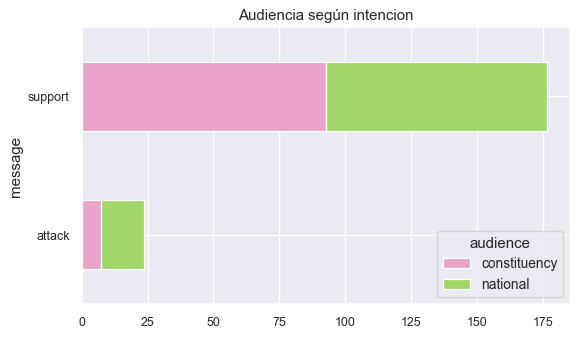

In [144]:
plt.rcParams.update({'figure.figsize':(7,4), 'figure.dpi':90})
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
ax = segun_audiencia_2[['constituency','national']].plot(kind ='barh', stacked=True,color = ("#e9a3c9", "#a1d76a"))
ax.set_title('Audiencia según intencion')
plt.show()

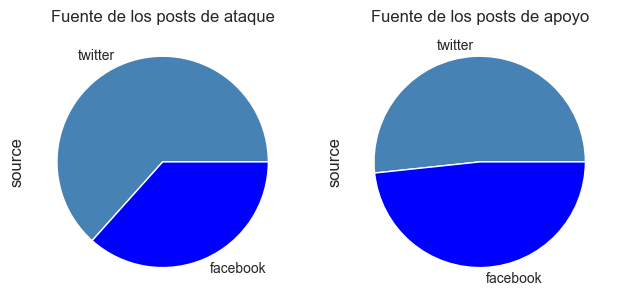

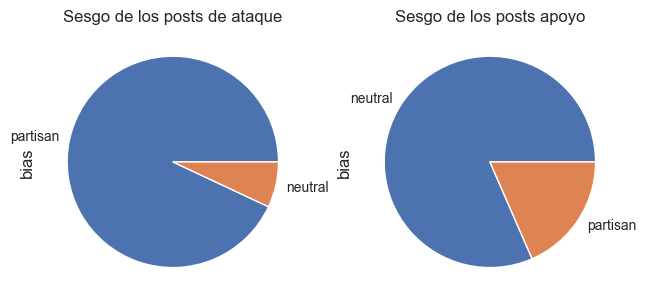

In [143]:
plt.rcParams.update({'figure.figsize':(7.5,7), 'figure.dpi':100})

fig, axes = plt.subplots(nrows=1, ncols=2)
political_posts_attack.source.value_counts().plot(ax=axes[0], kind ='pie', title = 'Fuente de los posts de ataque',colors = ['steelblue', 'blue'])
political_posts_support.source.value_counts().plot(ax=axes[1],kind ='pie', title = 'Fuente de los posts de apoyo',colors = ['steelblue', 'blue'])
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2)
political_posts_attack.bias.value_counts().plot(ax=axes[0], kind ='pie', title= 'Sesgo de los posts de ataque')
political_posts_support.bias.value_counts().plot(ax=axes[1],kind ='pie', title= 'Sesgo de los posts apoyo')
plt.show()

Aunque no sea tnata la diferencia, en los posts de apoyo hay un nivel más parejo de la fuente de lso mensajes, mientras que es los de ataque son mayormente de twitter.
Con respecto al sesgo, notamos una diferencia muy notable. Los de ataque son mayormente con un sesgo partidario, mientras que los de apoyo son neutrales

Con respecto a las palabras:
- Ataque:
    - Obama
    - Obamacare
    - Costs
    - Higher
    - Stuck
    - Spawning
    - Venezuela
- Apoyo:
    - Join
    - Please
    - Great
    - Vote
    - Share
    - Applaud
    - Clinton

In [149]:
df.groupby(['message']).agg(
    cantidad_de_caracteres =  ('cantidad_caracteres', 'mean'))


,cantidad_de_caracteres
message,
attack,203.918605
support,206.707926


In [150]:
df.groupby(['message']).agg(
    cantidad_de_hashtags =  ('cantidad_hashtag', 'mean'))


,cantidad_de_hashtags
message,
attack,0.703488
support,0.535288


In [151]:
df.groupby(['message', 'cargo']).agg(
    cantidad_de_posts =  ('unit_id', 'count')).pivot_table( values='cantidad_de_posts', index=['message'],columns=['cargo']).apply(lambda x: x/x.sum() * 100)

cargo,Representative,Senator
message,,
attack,16.3031,13.513514
support,83.6969,86.486486


Con respecto a estos 3 últimos agrupamientos realizados, parecen no ser influyentes.